In [85]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from dependency_decoding import chu_liu_edmonds
from pathlib import Path
from collections import defaultdict
import warnings

In [86]:
sent = np.load("en.1.npz")
T_proj = sent['projection_tensor']
source_langs = sent['source_languages']

In [87]:
def count_correct(pred_heads, gold_heads):
    assert len(pred_heads) == len(gold_heads)
    # Do not count the root attachment at index 0 as correct
    return sum(pred == gold for pred, gold in zip(pred_heads, gold_heads)) - 1


In [88]:
def add_root_row(T):
    first_row = np.zeros([1, T.shape[1], T.shape[2]]) * np.nan
    return np.vstack([first_row, T])
    
T_proj = add_root_row(T_proj)
T_proj_de = T_proj[:,:,4]



D = pd.DataFrame(T_proj_de)
D

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.814724,NaN,9.447473e-05,0.900435,0.192033,0.420597,NaN,0.105496,NaN,NaN,NaN,3.411754e-04
2,-0.000261,0.000026,4.620701e-05,0.440397,0.093922,0.205711,9.148190e-09,0.051597,-0.000150,NaN,-0.000035,1.668668e-04
3,-2.483845,0.251571,1.230419e-01,NaN,0.077179,1.251440,8.719103e-05,0.384532,-1.433711,NaN,-0.338229,2.467738e-04
4,-2.001916,-0.273783,-2.026755e-05,-0.193169,NaN,1.067544,-9.488932e-05,0.911320,-1.235253,NaN,-0.219997,-2.685620e-04
5,-0.429096,-0.022297,-2.962642e-05,-0.282368,0.182370,NaN,-7.727927e-06,0.512244,NaN,NaN,-0.424536,3.240084e-04
6,-0.000629,NaN,3.274361e-08,0.000312,0.000067,0.000146,NaN,0.000037,NaN,NaN,NaN,1.182466e-07
7,-1.502256,-0.363040,-4.669691e-05,-0.445066,0.753000,1.101405,-1.258244e-04,NaN,-0.909588,NaN,-0.167354,1.337820e-03
8,NaN,-0.290791,1.728895e-06,0.016478,1.099066,0.409479,-1.007841e-04,1.838423,NaN,NaN,0.246433,1.952661e-03
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
np.nanmin(T_proj_de)

-2.4838451914699999

In [90]:
T_proj_de[2] = np.nanmin(T_proj_de)
T_proj_de[6] = np.nanmin(T_proj_de)
T_proj_de[9] = np.nanmin(T_proj_de)

pred_heads, tree_score = chu_liu_edmonds(T_proj_de)
gold_heads = np.concatenate([[-1], sent["heads"]])
print(pred_heads, gold_heads)
count_correct(pred_heads, gold_heads)

[-1, 3, 0, 5, 5, 6, 0, 5, 7, 0, 7, 7] [-1  3  3  4  5  0  7  5  7 10  7  5]


5

In [93]:
#import warnings
#warnings.filterwarnings('ignore', r"")

p = Path(".")
scores = defaultdict(list)
sent_lens = []
tree_scores = defaultdict(list)

def softmax(sentence_matrix, temperature=1.0):
    m_exp = np.exp(sentence_matrix/temperature)
    return (m_exp.T / np.nansum(m_exp, axis=1)).T

def l1_normalize(M):
    return (M.T / np.nansum(M, axis=1)).T

def eliminate_all_nan_rows(M_proj):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        by_row = np.nanmax(M_proj, axis=1)
        all_nan_rows = np.isnan(by_row)
        M_proj[all_nan_rows] = np.nanmin(M_proj)

def eval_projection(M_proj, name):
    eliminate_all_nan_rows(M_proj)
    pred_heads_from_all, tree_score = chu_liu_edmonds(M_proj)
    scores[name].append(count_correct(pred_heads_from_all, gold_heads))
    tree_scores[name].append(tree_score)

def apply_softmax_per_row_per_lang(T_proj):
    for lang in range(T_proj.shape[2]):
        T_proj_lang = T_proj[:,:,lang]
        T_proj[:,:,lang] = softmax(T_proj_lang, temperature=1)
    
token_count = 0




for file in p.glob("*.npz"):
    sent = np.load(str(file))
    T_proj = sent['projection_tensor']
    
    #print(T_proj.shape[2])
    #if T_proj.shape[2] < 15:
    #    print(T_proj.shape[2])
    #    continue
    
    source_langs = sent['source_languages']
    T_proj = add_root_row(T_proj)
    
    apply_softmax_per_row_per_lang(T_proj)
    
    gold_heads = np.concatenate([[-1], sent["heads"]])
    for lang in range(T_proj.shape[2]):
        lang_name = source_langs[lang]
        
        T_proj_lang = T_proj[:,:,lang]
        T_proj_lang = np.where(np.isnan(T_proj_lang), np.nanmin(T_proj_lang), T_proj_lang)
        pred_heads, tree_score = chu_liu_edmonds(T_proj_lang)
        
        scores[lang_name].append(count_correct(pred_heads, gold_heads))
        tree_scores[lang_name].append(tree_score)
        
        
    # Aggregate measures
    good_lang_ids = [i for i, lang_name in enumerate(source_langs)
                     if lang_name in ["fr", "de", "es", "sv", "no", "da"]]
    
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_projection(np.nansum(T_proj, axis=2), "all_sum")
        eval_projection(np.nanmean(T_proj, axis=2), "all_mean")
        eval_projection(np.nanmax(T_proj, axis=2), "all_max")

        eval_projection(softmax(np.nansum(T_proj, axis=2)), "all_sum_softmax")
        eval_projection(softmax(np.nanmean(T_proj, axis=2)), "all_mean_softmax")

        eval_projection(l1_normalize(np.nansum(T_proj, axis=2)), "all_sum_l1")
    
    
    sent_lens.append(len(pred_heads) - 1)
    token_count += len(pred_heads) - 1

aggregated_scores = {k: sum(vals) for k, vals in scores.items()}
aggregated_tree_scores = {k: np.nansum(vals) for k, vals in tree_scores.items()}
print(token_count)
pd.DataFrame({"tree_score": pd.Series(aggregated_tree_scores), 
              "accuracy": pd.Series(aggregated_scores)})

3032


,accuracy,tree_score
all_max,1470,1268.146667
all_mean,1752,403.579912
all_mean_softmax,1753,203.886650
all_sum,1743,7436.237583
all_sum_l1,1743,391.108592
all_sum_softmax,1754,693.475312
ar,693,411.095047
bg,1091,602.754560
cs,842,441.904718
da,933,486.329076


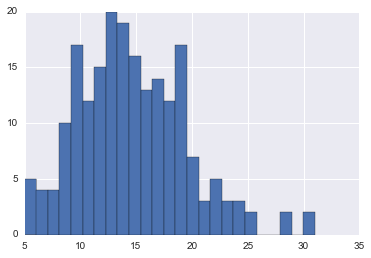

In [84]:
D = pd.DataFrame({"accuracy": np.array(scores["all_sum"])  / np.array(sent_lens), 
                  "tree_score": np.array(tree_scores["all_sum"]),
                  "norm_tree_score": np.array(tree_scores["all_sum"]) / np.array(sent_lens),
                  "sent_lens": np.array(sent_lens)}
                )

#for i in range(11):
#    print(D[D.accuracy > i / 10].sent_lens.mean())

D.sent_lens.hist(bins=25)
#D[D.sent_lens > 35].accuracy.mean()




In [9]:
sent['heads']

array([ 3,  3,  0,  5,  3,  3,  3,  3, 10,  3, 12, 10, 10, 10,  3, 17, 15,
       17,  3, 21, 15, 23,  3, 26, 27, 27, 23, 27, 30, 27, 33, 33, 30, 37,
       37, 37, 27,  3])

In [10]:
x = np.zeros(M_norm.shape[1]) * np.nan
M_norm = np.vstack([x, M_norm])
chu_liu_edmonds(M_norm)

AssertionError: Score matrix must be square